# Kittens and Cats (medium mode)

In this notebook we'll use [fastai](http://docs.fast.ai) to classify pictures of cats as either 'kittens' or 'cats'. I anticipate this will be harder than our previous work classifying paintings because kittens and cats share many, many features. 

We begin by setting up our notebook and importing the fastai libraries:

In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate

## Looking at the data

Our data exists in the `data/kittencat/` directory. We'll create an `ImageDataBunch` and make sure we can visually tell the difference between kittens and cats.

In [2]:
path = 'data/kittencat/'

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)


In [3]:
data.classes

['cat', 'kitten']

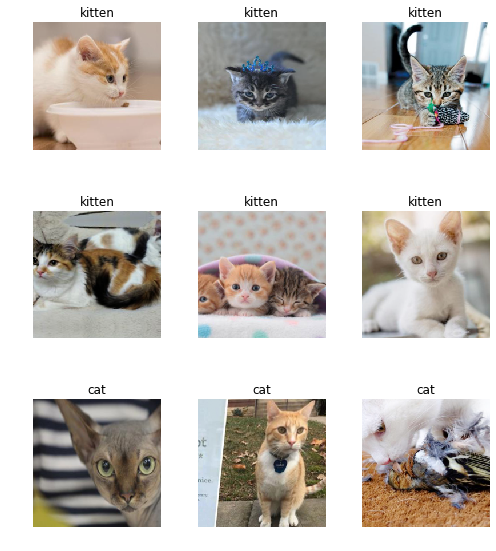

In [4]:
data.show_batch(rows=3, figsize=(7,8))

## Training a model

Now that we've got our data and it looks correct, let's create a learner for this data. We'll use a ResNet-34 architecture and train for five epochs to get a sense for how we're doing.

In [5]:
learner = create_cnn(data, models.resnet34, metrics=error_rate)

In [6]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate
1,0.887721,0.633843,0.378788
2,0.732651,0.336768,0.136364
3,0.569540,0.282584,0.136364
4,0.492754,0.278653,0.151515
5,0.425181,0.280318,0.136364


So we're looking at about 86% accuracy. Not quite the 95% we saw when classifying paintings but perhaps we can push it a little higher by choosing a good learning rate and running our model for longer.

In [7]:
learner.save('stage-1')

In [8]:
learner.unfreeze()

In [9]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


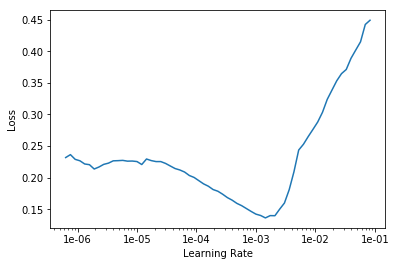

In [10]:
learner.recorder.plot()

Once again it looks like there is a sweet spot between `1e-5` and `1e-3`. We'll shoot for the middle and use `1e'4` and run for more epochs.

In [11]:
learner.fit_one_cycle(15, max_lr=slice(1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.216681,0.285061,0.121212
2,0.228469,0.287646,0.121212
3,0.242256,0.277071,0.136364
4,0.240099,0.265943,0.136364
5,0.225475,0.257672,0.136364
6,0.206698,0.251990,0.121212
7,0.197840,0.245337,0.121212
8,0.187443,0.240109,0.106061
9,0.175941,0.223304,0.090909
10,0.172302,0.220980,0.090909


Not bad! With minimum tuning we were able to get a validation accuracy of about `92%` which is better than I expected considering we had fewer than 200 examples of each class.

Let's take a minute to examine the top losses and see which examples our learner got "most wrong".

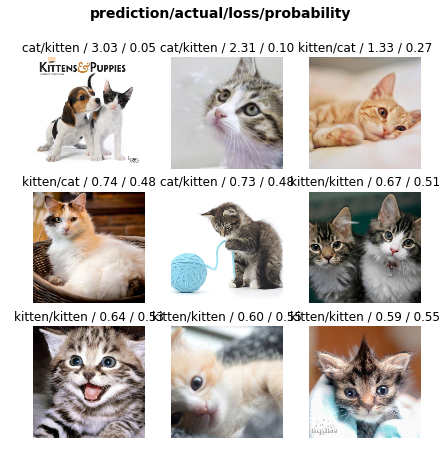

In [18]:
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)
interp.plot_top_losses(9, figsize=(7,7))

To be honest I'm not sure if there is anything actionable to be done at this point. There doesn't seem to be a clear pattern to me regarding the types of images our learner gets incorrect. Some are zoomed in, some have two cats and one has a dog with text, but no pattern jumps out at me.